### Module import

In [74]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LSTM, Dropout, Reshape
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import load_model


"""
import tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout
"""
%matplotlib inline

In [75]:
"""
file_path = '/home/dwkim/anno/introns_to_mercer.tsv'
introns = {}
with open(file_path) as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        print(start, end, three, strand, bp)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        # this code have error : cause always first data is null array 
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        # why reinsert bp data?
        if bp != -1: introns[key] += [bp]
"""

"\nfile_path = '/home/dwkim/anno/introns_to_mercer.tsv'\nintrons = {}\nwith open(file_path) as fp:\n    for line in fp:\n        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]\n        \n        bp, start, end = int(bp), int(start), int(end)\n        \n        three = end if strand == '+' else start  \n        key = (chrom, three, strand)\n        print(start, end, three, strand, bp)\n        \n        if not 5 < abs(bp - three) < 60:\n            bp = -1\n        # this code have error : cause always first data is null array \n        if key not in introns: introns[key] = []\n        assert bp not in introns[key], bp\n        # why reinsert bp data?\n        if bp != -1: introns[key] += [bp]\n"

In [76]:
known   = {key: value for key, value in introns.items() if value} # brancho point is not null
missing = {key: value for key, value in introns.items() if not value} # branch point is null
print(len(known))
print(len(missing))

37110
169182


In [77]:
L = 70
bases = ['A', 'C', 'G', 'T']

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms = [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    X += [onehot(seq).reshape(1, 70, 4)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]

X, y = np.vstack(X), np.vstack(y)
print(X.shape, y.shape, len(chroms))

NameError: name 'genome' is not defined

In [81]:
import os

os.path.dirname(os.path.realpath(__name__))

'/home/dwkim/project/labranchor_v2/notebooks'

In [82]:
X_train, X_valid, X_test = np.load('./X_train.npy'), np.load('./X_valid.npy'), np.load('./X_test.npy')
y_train, y_valid, y_test = np.load('./Y_train.npy'), np.load('./Y_valid.npy'), np.load('./Y_test.npy')
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(25711, 70, 4) (7093, 70, 4) (4306, 70, 4)
(25711, 70) (7093, 70) (4306, 70)


In [83]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

In [84]:
K = 3
counts = np.zeros((2*K+1, 4))
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1]
print(counts.T)

[[ 8658.  8037.  8984. 20929.  9468.  9994.  9281.]
 [12046.  8055. 11683.  6820. 11738. 11016. 10508.]
 [ 8100.  7269.  8965.  5728.  8041.  7817.  8519.]
 [10247. 15690.  9419.  5574.  9804. 10224. 10743.]]


In [89]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 15, EPOCHS = 50):
        print(self.model.summary())
        #tqdm_callback = tfa.callbacks.TQDMProgressBar()
        for i in range(EPOCHS):
            self.model.fit(X_train, y_train, epochs = 1, verbose = 0, batch_size = 32)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_match[-PATIENCE:])
                < max(self.valid_match)):
                break
            print(i, self.valid_match[-1], self.train_match[-1])
        self._plot_scores()
        print(max(self.valid_match), max(self.valid_auc))
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict(X_valid, verbose=0)
        train_preds = self.model.predict(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match, label = 'Validation')
        plt.plot(self.train_match, label = 'Training')
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        plt.plot(self.valid_auc, label = 'Validation')
        plt.plot(self.train_auc, label = 'Training')
        plt.ylabel('auROC') 
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [90]:
new_model = load_model('./2layer2.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 70, 64)           9472      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 70, 64)           24832     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 70, 1)            65        
 ibuted)                                                         
                                                                 
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 70, 64)           9472      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 70, 64)           24832     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 70, 1)            65        
 ibuted)                                                         
                                                                 
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None


2021-12-08 15:25:46.497849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0 0.611870858592979 0.6746917661701217
1 0.6110249541801777 0.6761308389405313
2 0.593119977442549 0.6673797207420948
3 0.6113069223177781 0.6740305705729065
4 0.596926547300155 0.651666601843569
5 0.6125757789369801 0.6697522461203376
6 0.598759340194558 0.6555948815682003
7 0.6127167630057804 0.672863754813115
8 0.6203299027209925 0.6760141573645522
9 0.6103200338361765 0.6706856987281709
10 0.6066544480473707 0.669830033837657
11 0.6196249823769914 0.6800980125238225
12 0.6039757507401664 0.6627902454202481
13 0.5580149443112928 0.6210182412197114
14 0.5874806146905399 0.6588619656956166
15 0.6021429578457634 0.6637236980280814
16 0.6128577470745806 0.6784644704601144
17 0.611870858592979 0.6661740111236436
18 0.614972508106584 0.6755863249192953
19 0.5392640631608628 0.6016102057485123
20 0.6111659382489779 0.6728248609544553
21 0.6098970816297759 0.6716969390533235
22 0.6125757789369801 0.6748473416047606


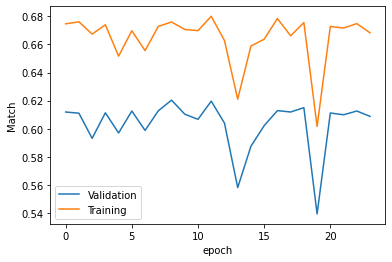

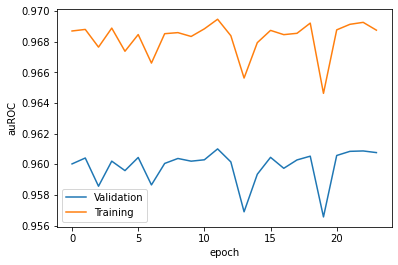

0.6203299027209925 0.9610038761547732


In [91]:
ModelTrainer(model=new_model).train(X_train[:, :, :4], X_valid[:, :, :4],
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [94]:
new_model.save('./2layer2.h5')


In [92]:
import pandas as pd
pd.read_csv('/home/dwkim/anno/introns_to_mercer.tsv', sep="\t")

,chr1,135802,135902,ENSG00000237683.5:ENST00000423372.3:AL627309.1,137620,-,.,-1,-1.1,..1,-1.2,..2
0,chr1,738618,738718,ENSG00000269831.1:ENST00000599533.1:AL669831.1,738787,-,.,-1,-1,.,-1,.
1,chr1,738812,738912,ENSG00000269831.1:ENST00000599533.1:AL669831.1,739120,-,.,-1,-1,.,-1,.
2,chr1,819395,819495,ENSG00000269308.1:ENST00000594233.1:AL645608.2,818058,+,.,-1,-1,.,-1,.
3,chr1,819860,819960,ENSG00000269308.1:ENST00000594233.1:AL645608.2,819513,+,.,-1,-1,.,-1,.
4,chr1,861201,861301,ENSG00000187634.6:ENST00000420190.1:SAMD11,860328,+,chr1,861273,861274,chr1_861273_861274_A,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...
227042,chrY,59337019,59337119,ENSGR0000124334.12:ENSTR0000369423.2:IL9R,59336526,+,.,-1,-1,.,-1,.
227043,chrY,59337848,59337948,ENSGR0000124334.12:ENSTR0000244174.5:IL9R,59337236,+,.,-1,-1,.,-1,.
227044,chrY,59338653,59338753,ENSGR0000124334.12:ENSTR0000244174.5:IL9R,59338150,+,.,-1,-1,.,-1,.
227045,chrY,59340093,59340193,ENSGR0000124334.12:ENSTR0000244174.5:IL9R,59338859,+,.,-1,-1,.,-1,.


In [45]:
import re
seq ='chr1:925952-925952G>A'

In [46]:
reg = '([^:]+):([0-9,]+)-([0-9,]+)([actgaACTG]+)([>]+)([actgACTG]+)'

rm = re.match(reg, seq)

#if rm.group(4) == ('>' or '<'):
    

In [47]:
rm.group(5)

'>'

In [49]:
if rm != None:
    if rm.group(5) == ('>' or '<'):
        print(f"{rm.group(1)}:{rm.group(2)}-{rm.group(3)} {rm.group(4)}{rm.group(5)}{rm.group(6)}")


chr1:925952-925952 G>A


In [51]:
import numpy as np
cal = [-3.85, -3.85]

In [52]:
np.mean(cal)

-3.85